# OpenFOAM TemporalProbe Analysis

This program shows the evolution of multiple temporal probes for an OpenFOAM case.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 30/05/2021
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
# Load modules
import numpy as np
import glob
import tqdm
import matplotlib.pyplot as plt
%matplotlib notebook

In [16]:
case_dir = '/mnt/internal/2021_pmdi/les_pmdimv2_0.33x1.2_trial_134a15pcEtOH_smi'
variables = ['rho','y']

In [12]:
def load_variable(v):
    
    # Get all the data
    files = glob.glob(case_dir+'/temporalProbes/*/'+v)
    
    # Get the time steps
    t0s = [ float(f[len(case_dir)+1:].split('/')[1]) for f in files ]
    
    # Put them in order
    idx = np.argsort(t0s)

    # Read in the data, in order of the starting time of each subset of data.
    data = []
    for i in tqdm.tqdm(idx):
        data.append( np.genfromtxt(files[i]) )
    
    # Arrange the data into a single large matrix, truncating any repeated timesteps at the end of a run
    A = None
    tmax_last = 0.
    for d in data:
        
        t = d[:,0] # time [s]
        #print(d.shape,t.min(),t.max())
        
        if A is None: # copy
            A = d[...] 
        
        elif t.min() >= tmax_last: # no overlap
            A = np.vstack((A, d))
            
        else: # has overlap - discard end of previous run
            deltat = np.abs(A[:,0] - t.min())
            te = np.where( deltat == np.nanmin(deltat) )[0][0]
            A = np.vstack((A[:te-1], d))
            #print("\tTruncate %i rows" % (A.shape[0]-te))
            
        tmax_last = t.max()
        
    del data
        
    return A

In [13]:
# Calculate running average in each column of A (excepting 1st column which is time.)
def running_mean(A):
    B = np.zeros_like(A)
    B[:,0] = A[:,0]
    np.cumsum(A[:,1:],axis=0,out=B[:,1:])
    count = np.arange(B.shape[0])+1
    for col in range(1,B.shape[1]):
        B[:,col] /= count
    return B


In [17]:
D=[]
for v in variables:   
    D.append(load_variable(v))

100%|██████████| 12/12 [00:30<00:00,  2.55s/it]


<IPython.core.display.Javascript object>


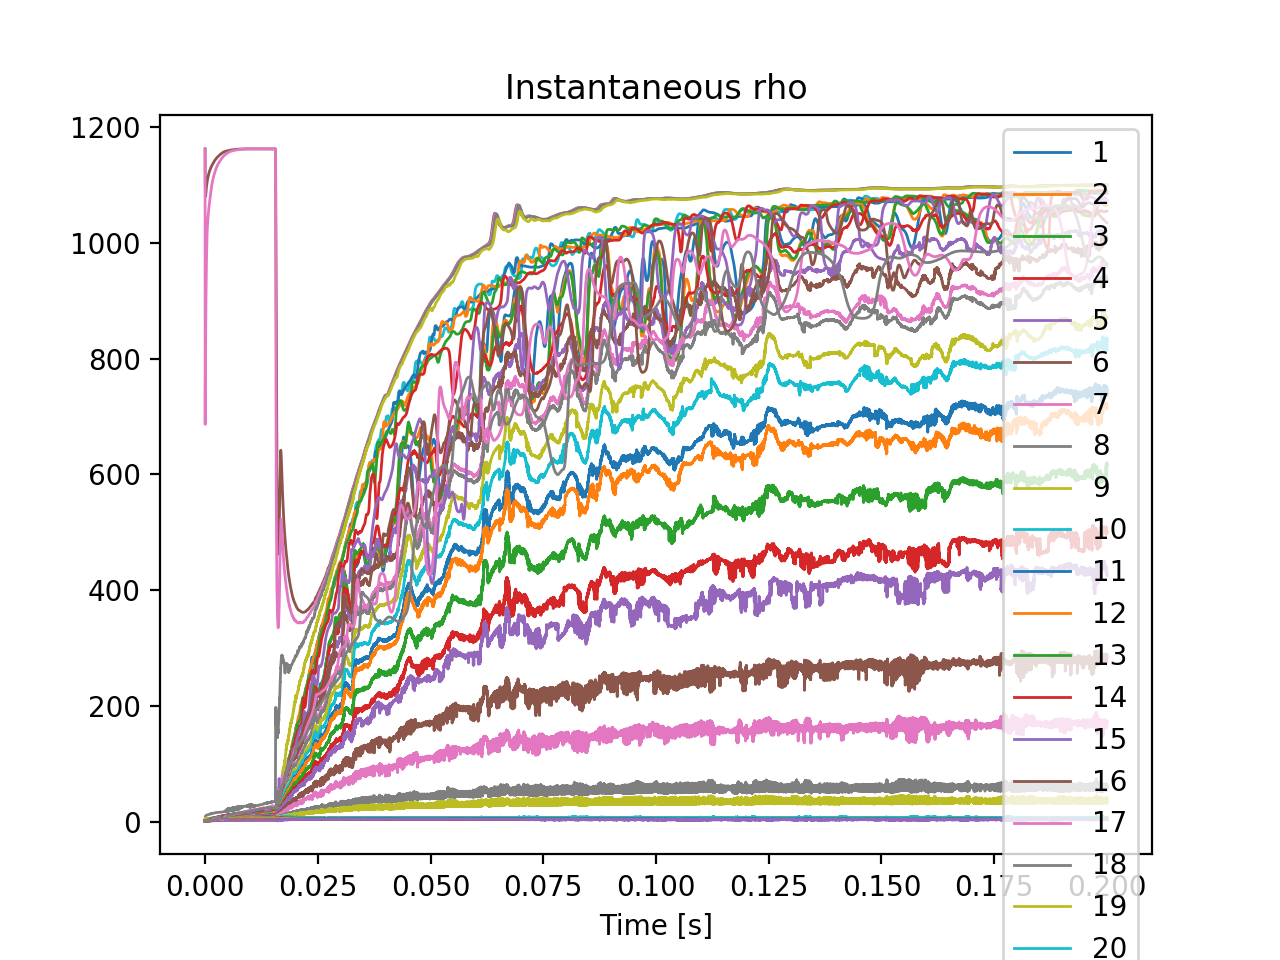

<IPython.core.display.Javascript object>


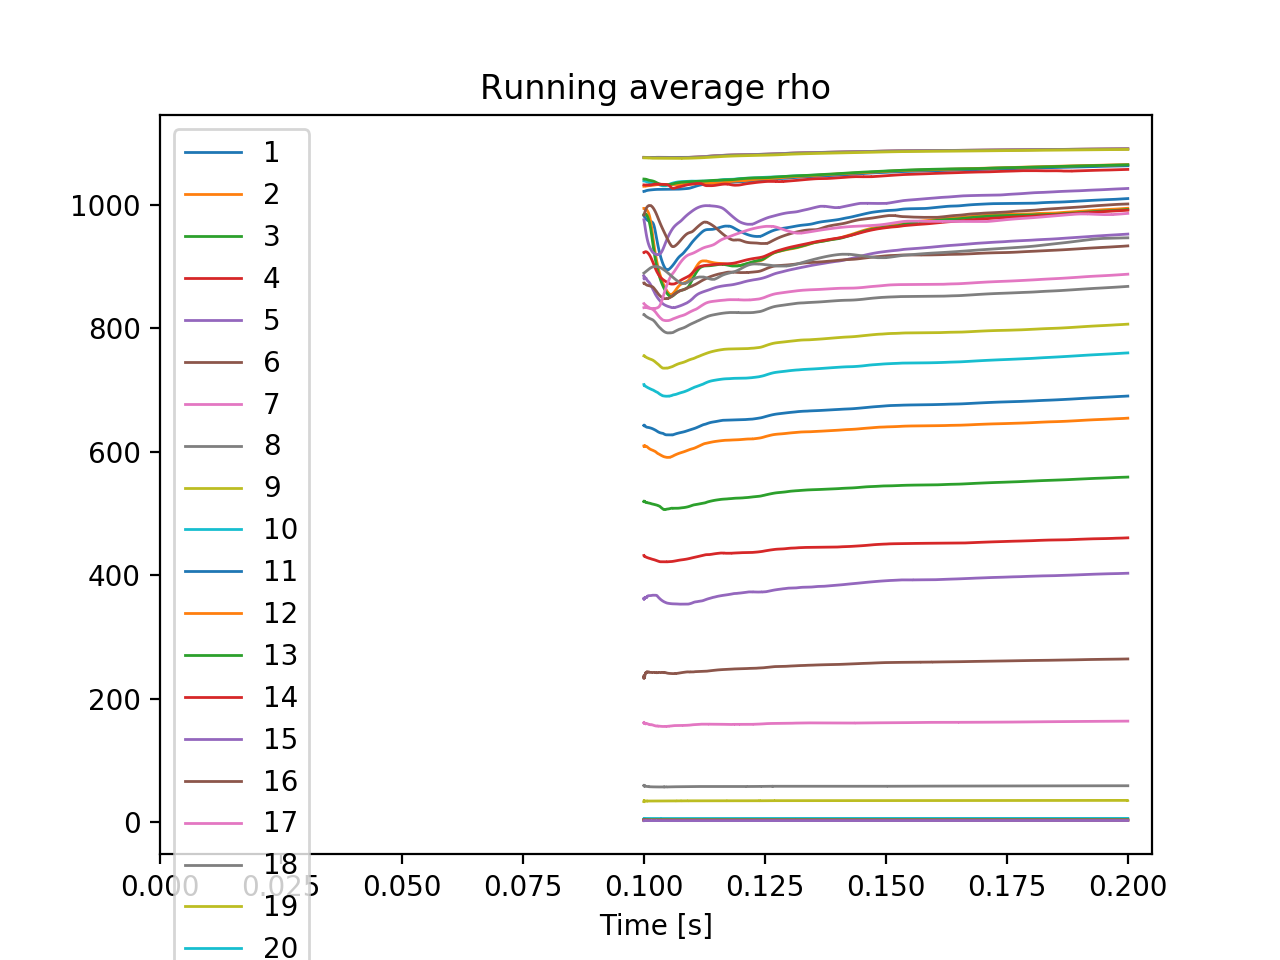

<IPython.core.display.Javascript object>


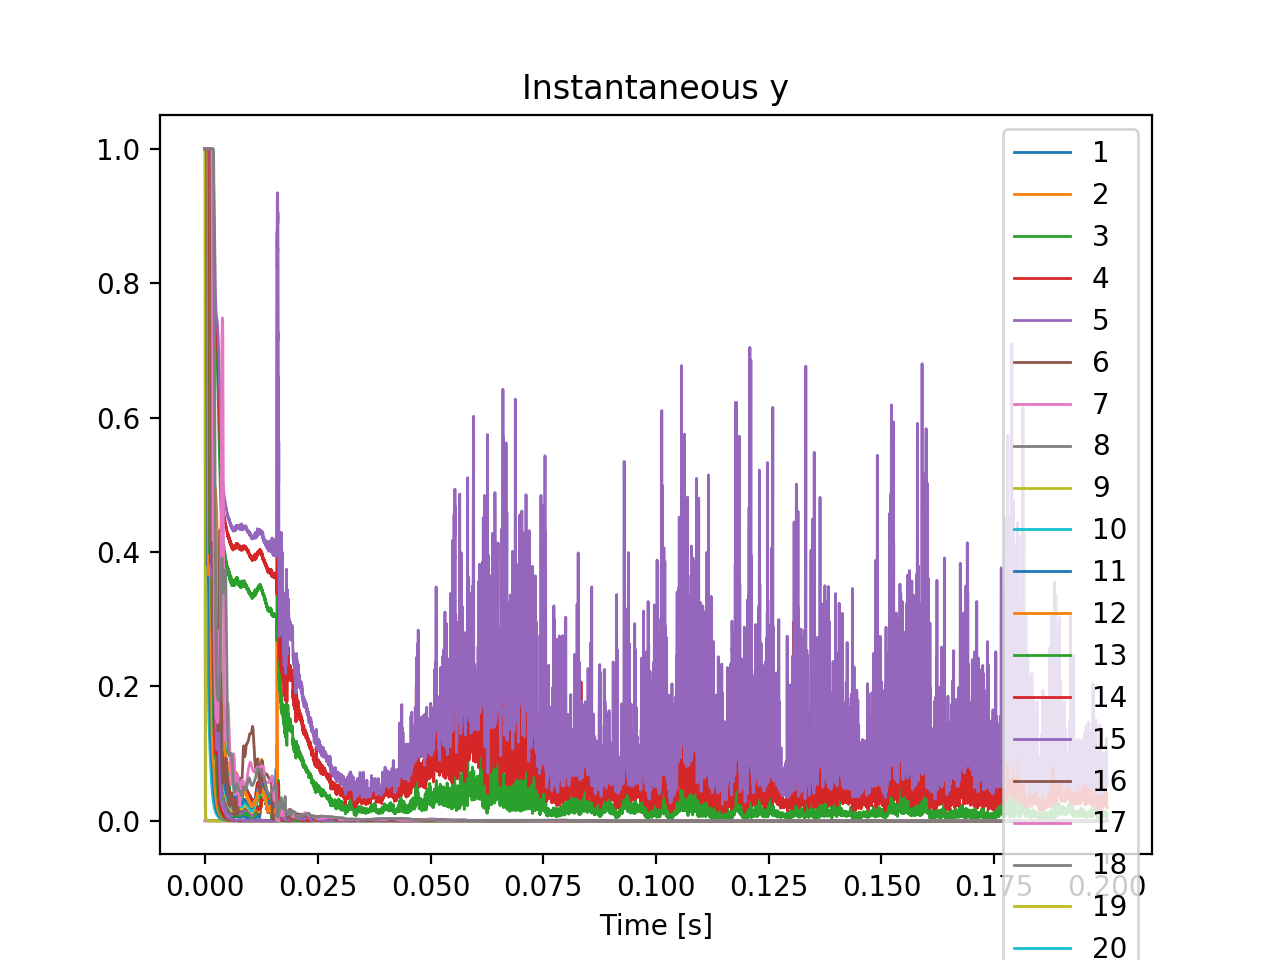

<IPython.core.display.Javascript object>


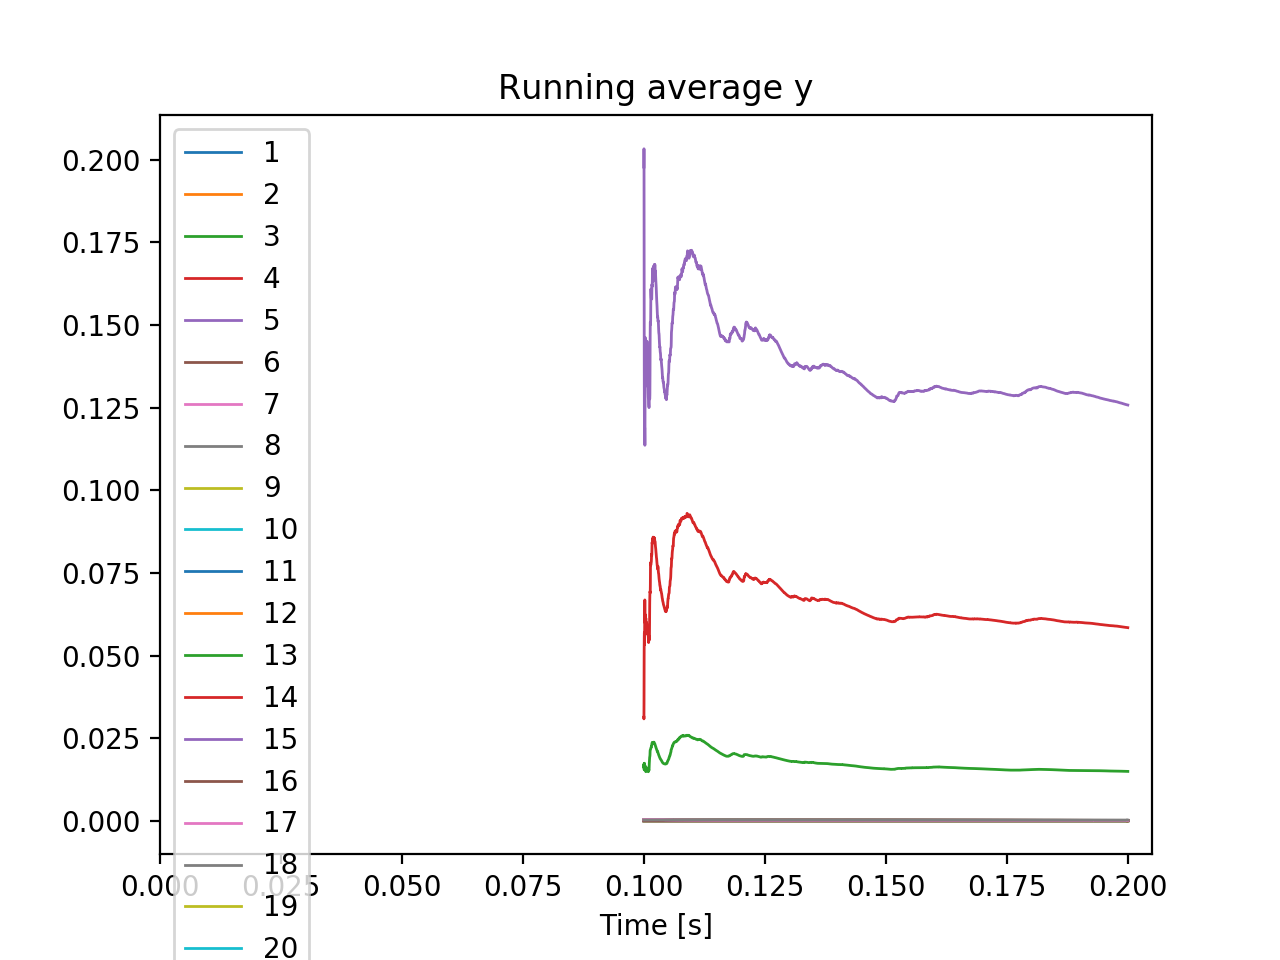

In [18]:
for i in range(len(variables)):
    A=D[i]
    v=variables[i]
    t = A[:,0]
    
    fig=plt.figure()
    for n in range(1,A.shape[1]):
        plt.plot(A[:,0], A[:,n], lw=1, label='%i' % n)
    plt.xlabel('Time [s]')
    #plt.legend()
    plt.title("Instantaneous "+v);
    
    t0 = np.where(t == 0.1 )[0][0] # fieldAverages started at t=0.1, start averaging here.
    B = running_mean(A[t0:,...])
    
    fig=plt.figure()
    for n in range(1,B.shape[1]):
        plt.plot(B[:,0], B[:,n], lw=1, label='%i' % n)
    plt.xlabel('Time [s]')
    plt.xlim(0,)
    #plt.legend()
    plt.title("Running average "+v);